# Initial test with spectral signal of gene trees

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sys, subprocess, time, dendropy, os
import numpy as np
from sklearn import manifold, metrics, cluster, neighbors, decomposition, preprocessing

bindir="/home/leo/local/bin/"
localdir="/tmp/"

In [2]:
def distance_signal (gtree, stree):
    os.chdir(localdir)
    gtree.write(path="gene.tre", schema="nexus")
    stree.write(path="species.tre", schema="nexus")
    proc_run = subprocess.run(bindir + "gf_distsignal_genetree_sptree gene.tre species.tre", shell=True, 
                              stdout=subprocess.PIPE, universal_newlines=True)

    x = [[float(i) for i in line.split()] for line in proc_run.stdout.splitlines()]
    return np.array(x)

In [3]:
def add_trees (tree1, tree2, first):
    otre = tree1
    for i in range(first, len(tree2)):
        otre.append(tree2[i])
    return otre

def add_noise (tree, n_noise):
    os.chdir(localdir)
    tree.write(path="tmp2.tre", schema="nexus")
    proc_run = subprocess.run([bindir + "bmc2_addTreeNoise", "tmp2.tre", "0.9", "0.1", str(n_noise)],
                              stdout=subprocess.PIPE, universal_newlines=True)
    return dendropy.TreeList.get(path="noise.tre", schema="nexus")

In [4]:
n_leaves = 32
def generate_trees (n_trees, n_spr, max_error, n_noise):
    os.chdir(localdir)
    proc_run = subprocess.run([bindir + "gf_generate_spr_trees", str(n_leaves), str(n_trees-1), str(n_spr)],
                              stdout=subprocess.PIPE, universal_newlines=True)
    with open("tmp.tre", "w") as trefile:
        print(proc_run.stdout, file=trefile)
    proc_run = subprocess.run([bindir + "bmc2_addTreeNoise", "tmp.tre", "0.9", str(max_error), str(n_noise)],
                              stdout=subprocess.PIPE, universal_newlines=True)
    return dendropy.TreeList.get(path="tmp.tre", schema="nexus"), dendropy.TreeList.get(path="noise.tre", schema="nexus")

In [5]:
g_sample_size = 5
n_loci = 9
st_skip = 5 # if st_skip == g_sample_size then it will not have the "true" gene trees
gt, st = generate_trees (g_sample_size,1,0.1, 5)
st = st[st_skip:] 
glabels = np.repeat(0,g_sample_size)
for i in range(n_loci):
    x,y = generate_trees (g_sample_size,1,0.1, 5)
    gt = add_trees(gt, x, 0)
    st = add_trees(st, y, st_skip)
    glabels = np.append(glabels,np.repeat(i+1, g_sample_size))

signal = distance_signal(gt, st)

print (signal, signal.shape)

[[   2.    9.    5. ...,   24.   56.  147.]
 [   1.    3.    1. ...,   22.   56.  144.]
 [   2.    7.    3. ...,   27.   56.  145.]
 ..., 
 [  20.  150.  110. ...,    2.   20.   12.]
 [  21.  152.  110. ...,    1.   18.   10.]
 [  20.  150.  110. ...,    0.    0.    0.]] (50, 1500)


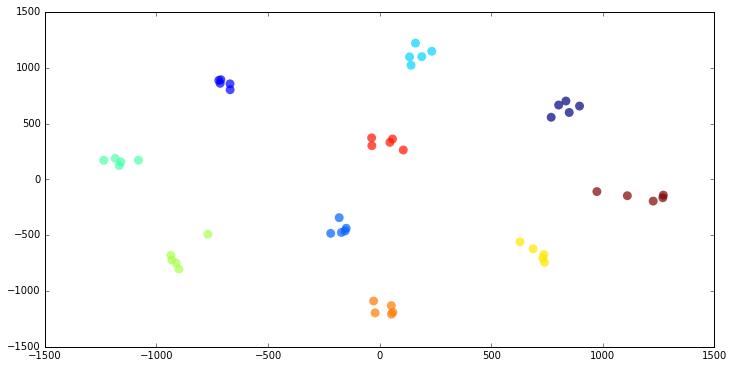

In [6]:
## species trees are composed of "noise" gene trees (without original ones)
transf=manifold.MDS(n_components=2).fit_transform(signal)
fig, axes = plt.subplots(1) ; fig.set_size_inches(12, 6)
axes.scatter(transf[:,1], transf[:,0], c=glabels, edgecolor="none", alpha=.7, s=80)

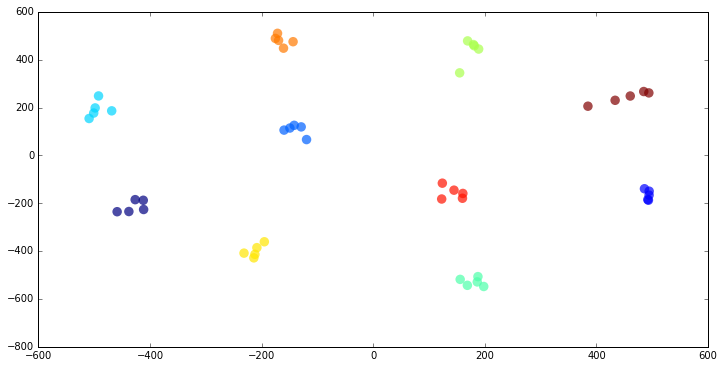

In [7]:
## species trees is set of gene trees (that is, usual distance-based MDS, but with several distances)
selftransf=manifold.MDS(n_components=2).fit_transform( distance_signal(gt, gt) )
fig, axes = plt.subplots(1) ; fig.set_size_inches(12, 6)
axes.scatter(selftransf[:,1], selftransf[:,0], c=glabels, edgecolor="none", alpha=.7, s=90)

250


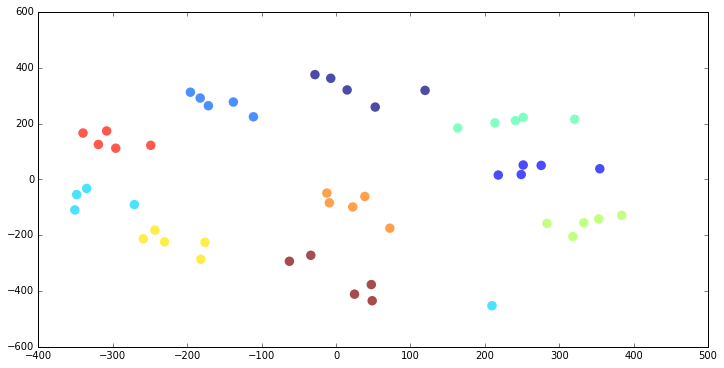

In [10]:
## species trees are completely random
rt, _  = generate_trees (250,20,0.1, 2)
print (len(rt))
selftransf=manifold.MDS(n_components=2).fit_transform( distance_signal(gt, rt) )
fig, axes = plt.subplots(1) ; fig.set_size_inches(12, 6)
axes.scatter(selftransf[:,1], selftransf[:,0], c=glabels, edgecolor="none", alpha=.7, s=90)

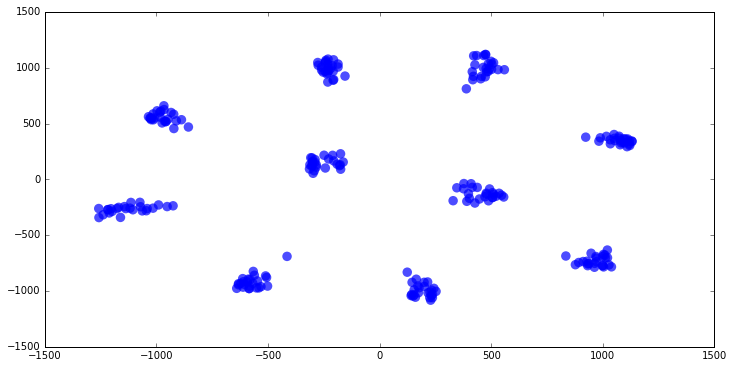

In [9]:
## distance mapping between (non-random) species trees
selftransf=manifold.MDS(n_components=2).fit_transform( distance_signal(st, st) )
fig, axes = plt.subplots(1) ; fig.set_size_inches(12, 6)
axes.scatter(selftransf[:,1], selftransf[:,0], edgecolor="none", alpha=.7, s=90)

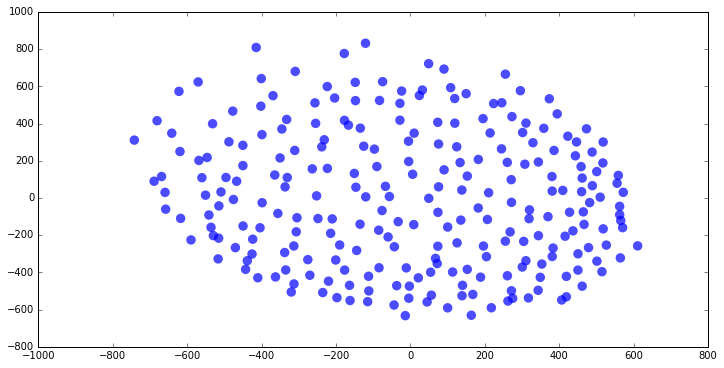

In [11]:
## distance mapping between (non-random) species trees
selftransf=manifold.MDS(n_components=2).fit_transform( distance_signal(rt, rt) )
fig, axes = plt.subplots(1) ; fig.set_size_inches(12, 6)
axes.scatter(selftransf[:,1], selftransf[:,0], edgecolor="none", alpha=.7, s=90)

### TODO:
- remove duplicates (in dendropy, since distsignal_genetree_sptree works with redundant set, not "distinct"
- simulate missing data and re-write distance_signal to work with missing data
- allow for 'smart' set of sptrees, besides 'random'
- functions should clean the localdir (once we are done with debugging)